# Residual model generation pipeline

In [1]:
import os
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

from LMCE.models import MLP
from LMCE.utils import min_max
from LMCE.trainers import train
import LMCE.cfusdlog as cfusdlog
import LMCE.uav_trajectory as uav_trajectory
from LMCE.data_prep import prepare_data, create_dataloader
from LMCE.residual_calculation import indi_residuals, residual
from LMCE.model_to_c_conversion import exportNet, nn_c_model_test
from LMCE.error_estimation import error_calculator, find_best_cutoff

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']

## Preparing the data
First define where the data is stored, then it can be loaded, the `prepare_data` function calculates the labels (residual forces).

In [2]:
# Get train data paths
indices = [i for i in range(0, 64)]
test_indices = [63]
for i in test_indices:
    del indices[i]
training_data_paths = [f"./data/indi_no_payload/li{i:02}" for i in indices]
testing_data_paths = [f"./data/indi_no_payload/li{i:02}" for i in test_indices]

residual_func = lambda data: indi_residuals(data, make_smooth=False, show_fit=True, spline_segments=200)

X_train, y_train_ = prepare_data(training_data_paths,
                                 save_as="train_data",
                                 residual_func=residual_func,
                                 overwrite=True,
                                 verbose=1)

amount = int(len(X_train)*.4)
amount = 7500
X_train = X_train[:amount]
y_train_ = y_train_[:amount]

X_test, y_test_ = prepare_data(testing_data_paths,
                               save_as="test_data",
                               shuffle_data=False,
                               residual_func=residual_func,
                               overwrite=True,
                               verbose=1)

100%|██████████| 1/1 [00:00<00:00, 12.38files/s]


In [3]:
_, X_mins, X_maxs = min_max(X_train.copy())
X_mins[:6] = -1.
X_maxs[:6] = 1.
X_train, _, _ = min_max(X_train, X_mins, X_maxs)
X_test, _, _ = min_max(X_test, X_mins, X_maxs)

y_train, y_mins, y_maxs = min_max(y_train_)
y_test, _, _ = min_max(y_test_, y_mins, y_maxs)

train_loader = create_dataloader(X_train, y_train)
val_loader = create_dataloader(X_test, y_test)

print("Train size: ", X_train.shape[0])
print("Test size: ", X_test.shape[0])
print("X dim: ", X_train.shape[1], "y dim: ", y_train.shape[1])

Train size:  7500
Test size:  478
X dim:  19 y dim:  6


We can plot the flight path and residual forces like this

li63 mean residual f_x: 0.010223030513553959
li63 mean residual f_y: -0.005067128012338993
li63 mean residual f_z: -0.001349190734226401


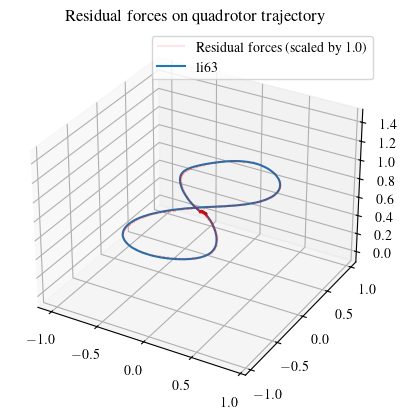

In [4]:
THREE_D = True

data_path = testing_data_paths[0]
visual_scale = 1.

if THREE_D:
    fig = plt.figure()
    ax = plt.axes(projection='3d')

data = cfusdlog.decode(data_path)['fixedFrequency']
label = os.path.basename(data_path)

x = [i for i in data["stateEstimate.x"]]
y = [i for i in data["stateEstimate.y"]]
z = [i for i in data["stateEstimate.z"]]
origin = np.array([x, y, z]).T

f, _ = residual_func(data)
vector = np.array([f[:, 0], f[:, 1], f[:, 2]]).T * visual_scale
if THREE_D:
    ax.quiver(origin[:, 0], origin[:, 1], origin[:, 2], vector[:, 0], vector[:, 1],
              vector[:, 2], color='r', alpha=.1, label=f"Residual forces (scaled by {visual_scale})")
else:
    plt.quiver(origin[:, 0], origin[:, 1], vector[:, 0], vector[:, 1], color='r',
              alpha=.1, label=f"Residual forces (scaled by {visual_scale})")

if THREE_D:
    ax.plot3D(x, y, z, label=label)
else:
    plt.plot(x, y, label=label)

# Calculate the avg. residual force for each axis
for j, v in enumerate(["x", "y", "z"]):
    f_j = [f_[j] for f_ in f]
    print(f"{label} mean residual f_{v}: {sum(f_j)/len(f_j)}")

plt.title("Residual forces on quadrotor trajectory")
plt.legend()
plt.axis('equal')
plt.show()

## Training the model

In [5]:
# Create and train neural network
model = MLP(input_size=X_train.shape[1], output_size=y_train.shape[1], hidden_layers=[24, 24, 24])
model = train(model, train_loader, val_loader, lr=3e-4, scheduler_gamma=.92, scheduler_step_size=10, device="cpu", epochs=128)
model.save("mlp_small_data")

100%|██████████| 128/128 [00:08<00:00, 15.68epoch/s, LR=0.00011, train_loss=0.0619, val_loss=0.0979]

Done!


## Testing the model

100%|██████████| 1/1 [00:00<00:00, 13.48files/s]
/var/folders/3s/hzwnx0js65nd8l8bktfqjfxw0000gn/T/ipykernel_77706/1347847813.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

(433, 6)
Average force error: (x, y, z) N -> (0.0676, 0.0803, 0.0945) N
Average torque error: (x, y, z) N -> (0.0689, 0.0397, 0.1685) N


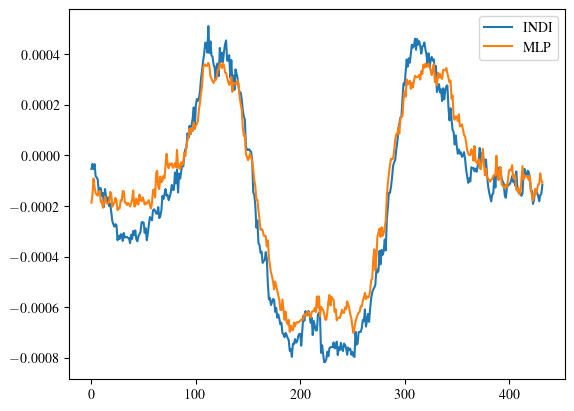

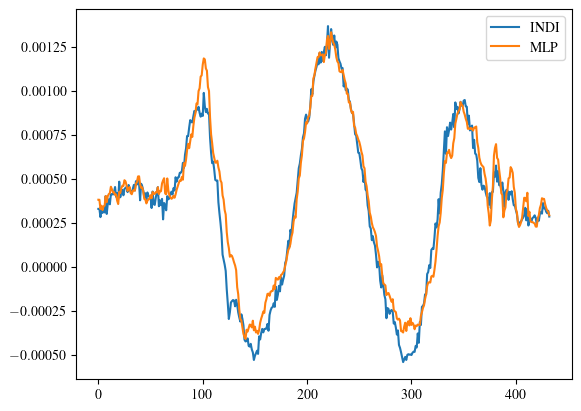

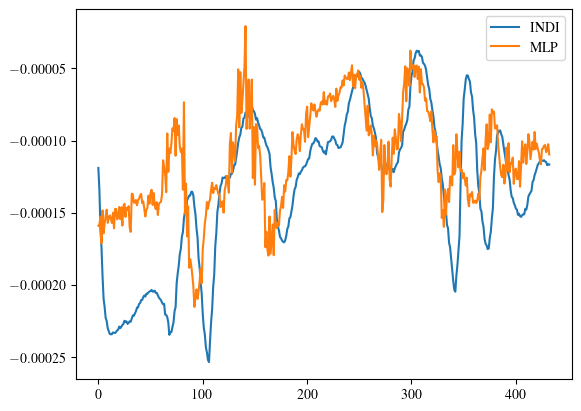

In [6]:
residual_func = lambda data: indi_residuals(data, make_smooth=False, show_fit=True)

X_test, y_test_ = prepare_data([testing_data_paths[0]],
                               save_as="test_data",
                               shuffle_data=False,
                               residual_func=residual_func,
                               overwrite=True,
                               payload=False,
                               verbose=1)
X_test, _, _ = min_max(X_test, X_mins, X_maxs)
y_test, _, _ = min_max(y_test_, y_mins, y_maxs)
X_test = X_test[45:]
y_test = y_test[45:]

print(y_test.shape)

weights = torch.load('./models/mlp_small_data.pth')
model.load_state_dict(weights)
model.float()

tensor_input = torch.from_numpy(X_test).type(torch.float32)
pred = model.forward(tensor_input).detach().numpy()
error = np.abs(y_test-pred)
print(f"Average force error: (x, y, z) N -> ({np.mean(error[:, 0]):.4f}, {np.mean(error[:, 1]):.4f}, {np.mean(error[:, 2]):.4f}) N")
print(f"Average torque error: (x, y, z) N -> ({np.mean(error[:, 3]):.4f}, {np.mean(error[:, 4]):.4f}, {np.mean(error[:, 5]):.4f}) N")

y_test_scaled = (y_test + 1) * .5 * (y_maxs - y_mins) + y_mins
pred_scaled = (pred + 1) * .5 * (y_maxs - y_mins) + y_mins

for i in range(3, 6):
    fig, ax = plt.subplots()
    ax.plot(y_test_scaled[:, i], label="INDI")
    ax.plot(pred_scaled[:, i], label="MLP")
    ax.legend()

    # axins = zoomed_inset_axes(ax, 3, loc=3)
    # axins.plot(y_test_scaled[:, i])
    # axins.plot(pred_scaled[:, i])

    # x1, x2, y1, y2 = 200, 240, .027, .037
    # axins.set_xlim(x1, x2)
    # axins.set_ylim(y1, y2)

    # plt.xticks(visible=False)
    # plt.yticks(visible=False)
    # mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.draw()
    plt.show()

## Translating the model to c code

In [7]:
# Generate the model c code
model_path = "./models/mlp.pth"
exportNet(model_path, X_mins=X_mins, X_maxs=X_maxs, y_mins=y_mins, y_maxs=y_maxs, info="Neural network for the 2.1 Crazyflie")

# Test if the generated model gives the same outputs as the original
model.double()
nn_c_model_test(model, X_mins=X_mins, X_maxs=X_maxs, y_mins=y_mins, y_maxs=y_maxs, in_dim=X_train.shape[1])

/Users/tupryk/Paper/LMCE/model_to_c_conversion.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pth_path)


Comparing with original...
Something went wrong, outputs dont match!


## Adding the model to the cf-firmware

In [8]:
try:
    shutil.copyfile("./LMCE/c_utils/nn.c", "../crazyflie-firmware/src/modules/src/controller/nn.c")
    shutil.copyfile("./LMCE/c_utils/nn.h", "../crazyflie-firmware/src/modules/interface/controller/nn.h")
    print("Successfully copied nn to firmware.")
except:
    print("Crazyflie firmware not found.")

Successfully copied nn to firmware.


## Error calculation
For calculating the error with the addition of the learning models the flights need to be re-recorded with the updated firmware.

In [9]:
# Get desired path
traj = uav_trajectory.Trajectory()
traj.loadcsv("./LMCE/flight_paths/figure8.csv")
traj.stretchtime(2)

ts = np.arange(0, traj.duration, 0.01)
evals = np.empty((len(ts), 15))
for t, i in zip(ts, range(0, len(ts))):
    e = traj.eval(t)
    e.pos += np.array([0, 0, 1])
    evals[i, 0:3] = e.pos

target_pos = evals.transpose()

# Get real path
data_path = "inditest/tle94"
try:
    data = cfusdlog.decode(data_path)['fixedFrequency']
    start = 190
    end = 500
    real_pos = [data["stateEstimate.x"][start:end], data["stateEstimate.y"][start:end]-1.]

    # Calculate error
    cutoff = find_best_cutoff(real_pos, target_pos)
    avg_error = error_calculator(cutoff, real_pos, target_pos, vis=True)
    print(f"Avg. error: {avg_error:.4f} (m)")
except:
    print("Test file not found.")

Test file not found.
